# Tuning the Richardson-Lucy Algorithm with 1D functions

Its faster and simpler to experiment with 1D functions than 2D images. The same algorithm is used in 1D as it is in 2D. Furthermore there is more 1D data than 2D data.

# Aims
- Understand how random noise is changed by convolution
- Test the Richardson-Lucy Algorithm (RLA) in 1D
- Tune the RLA parameters in order to maximize PSNR (peak signal to noise ratio) and SSIM (structural similarity index measure).
## Deconvolving a 1D signal
A square wave was convolved using a gaussian kernel and then poisson noise was added. The square wave was normalized between $0$ and $1$ as this was the 2D signal (image) was prepared as the same algorithms were used. The RLA was then used to try and recover the original signal.

In [8]:
import torch
import matplotlib.pyplot as plt
from ImageDebluring import *
from PIL import Image
from torchvision import transforms


def step_function(period=2.0):
    xs = torch.linspace(-5, 5, steps=1000)
    ys = (((xs.round() % period) == 0).float() + 0.2)/2
    return xs, ys

def sin_function(period=2.0):
    xs = torch.linspace(-5, 5, steps=1000)
    ys = (torch.sin(xs * (2 * torch.pi / period)) + 1) / 2
    return xs, ys

def pigeon_function():
    image = Image.open('Images/pigeon.jpeg').convert('L')  # Convert to grayscale
    transform = transforms.Compose([
        transforms.Resize((1, 1000)),  # Resize to 1x1000
        transforms.ToTensor()
    ])
    img_tensor = transform(image).squeeze()  # Remove channel dimension
    return torch.linspace(0, 10, steps=1000), img_tensor


def plot_deblurring_example(func, padding_mode = 'replicate', title = None, num_iters = 10, scale_factor = 5000):
    if title is None:
        title = func.__name__.replace('_', ' ').title()
    x, y = func()
    signal = y.unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions
    kernel = gaussian_normalised_kernel_1D(size = 61, sigma = 10.0)

    blurred_signal = convolution_1D(signal, kernel, padding_mode=padding_mode)
    measured_signal = add_poisson_noise(blurred_signal, scale_factor=scale_factor)

    deblurred_signal = richardson_lucy(measured_signal, kernel, num_iters=num_iters, padding_mode=padding_mode)

    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle(title, fontsize=16)
    axs[0, 0].plot(y)
    axs[0, 0].set_title('Step Function')
    axs[1, 0].plot(measured_signal.squeeze())
    axs[1, 0].set_title('Measured Signal (Blurred + Noisy)')
    axs[0, 1].plot(blurred_signal.squeeze())
    axs[0, 1].set_title('Blurred Signal')
    axs[1, 1].plot(deblurred_signal.squeeze())
    axs[1, 1].set_title(f'Estimated Signal (Richardson-Lucy, {num_iters} iters)')
    plt.tight_layout()

## Padding
After a convolution the size of the image decreases since the kernel cannot be applied around edge pixels. For a kernel of size $n$ and an image of size $m$ the convoluted image will have size $m-n+1$. This is problematic since the LRA requires the measured image and the kernel to be the same size. Padding increases the size of the image by adding pixels around the edge.
- Zeros padding: the easiest to implement form of padding. The edge pixels are set to zero. The problem with zeros padding is that overtime it will decrease the overall brightness of the image starting from the edges. This means that a more iterations will gradually decrease the brightness of the image.

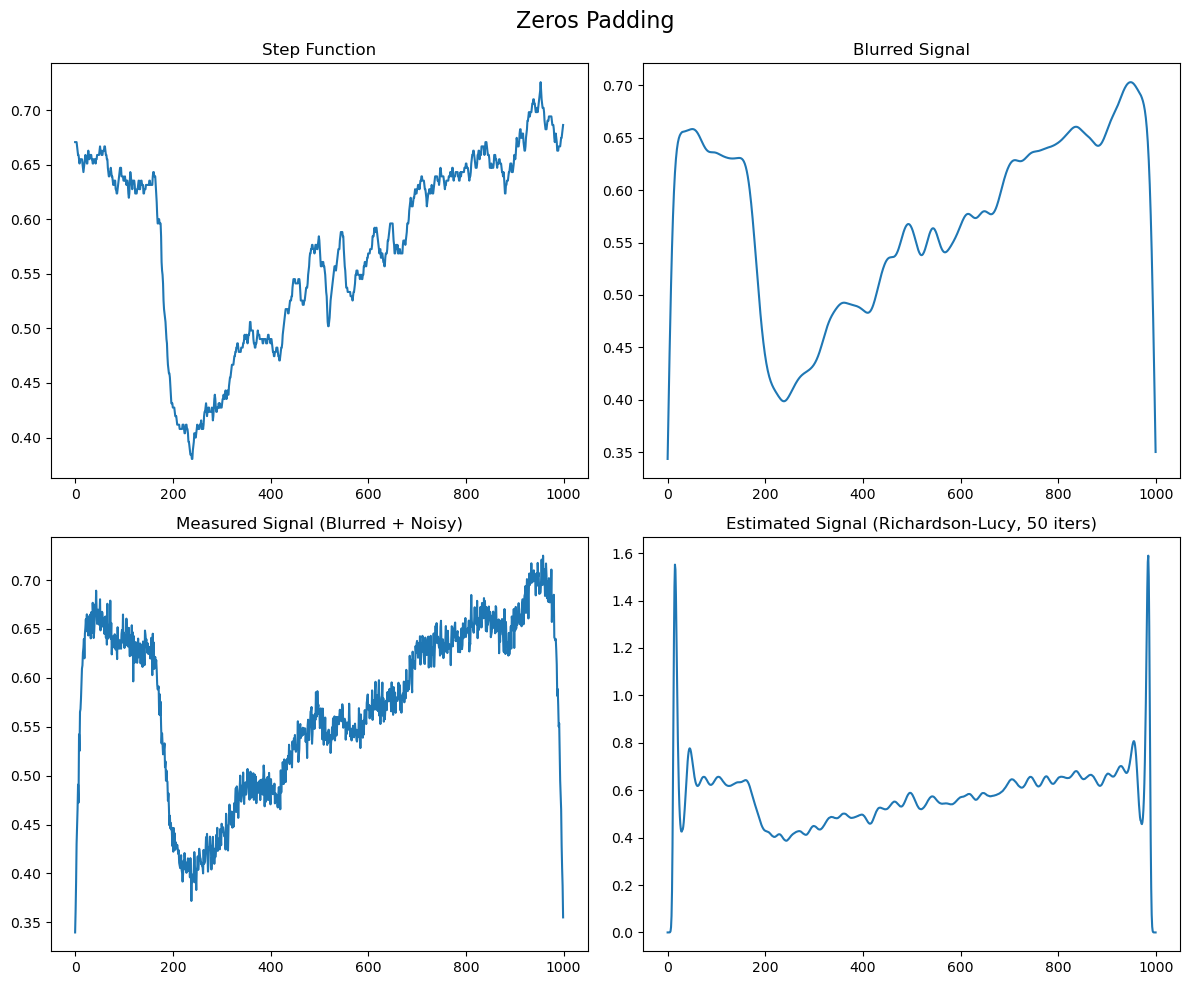

In [9]:
plot_deblurring_example(pigeon_function, padding_mode='zeros', title = 'Zeros Padding', num_iters = 50) 

The measured signal is far from the true signal since the edge pixels are much darker due to the zeros padding. Here there are also erroneous results since some pixel intensities are greater than 1.
- replicate padding repeats the value of the edge pixels. This means that the overall image is not darkened like when using zeros padding. 

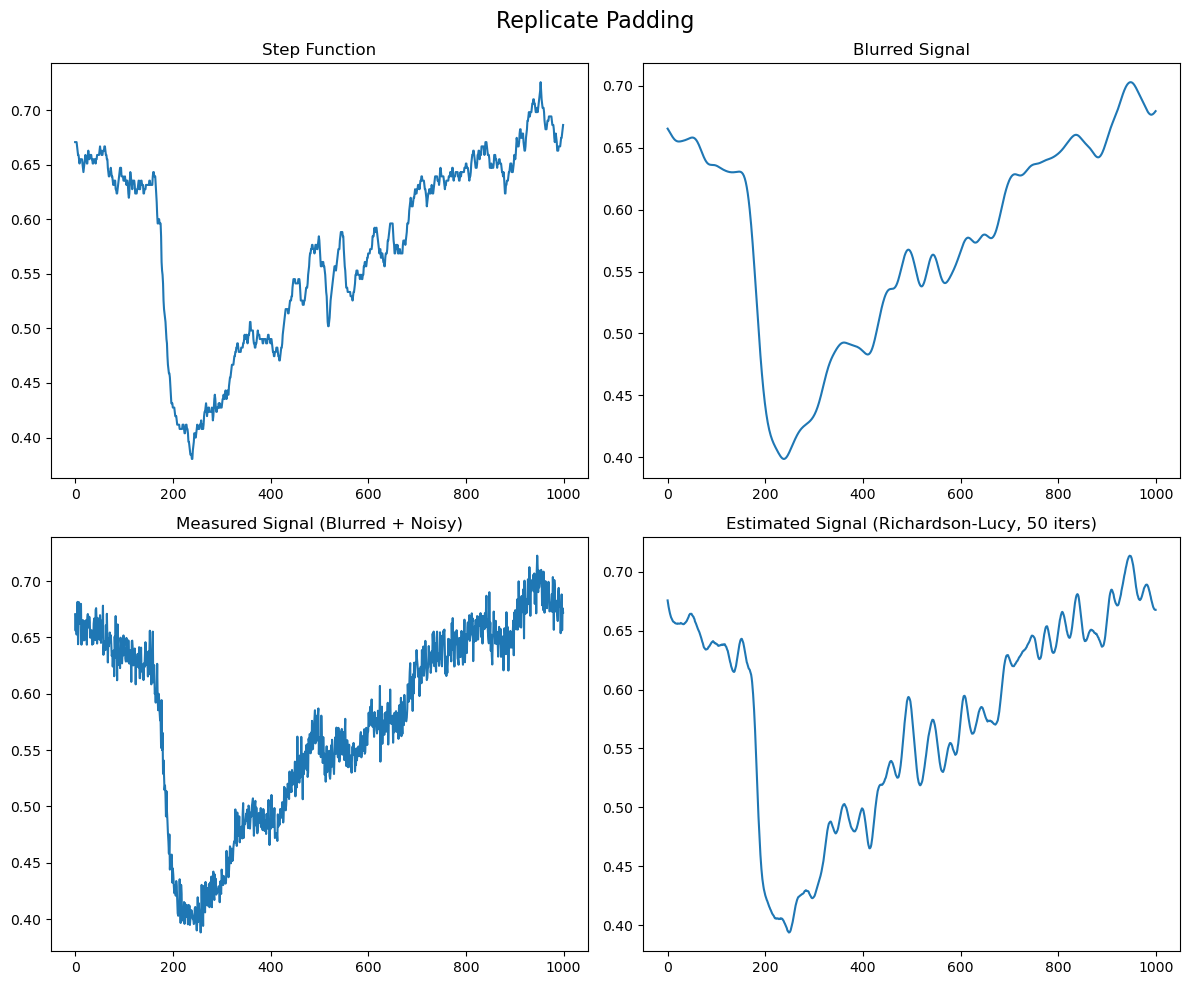

In [10]:
plot_deblurring_example(pigeon_function, padding_mode='replicate', title = 'Replicate Padding', num_iters = 50)

The replicate padding works much more successfully as there isn't issues around edge pixels. The image will not lose brightness over time.

## Measures of image quality
- $R^2$ measures the correlation between the estimated signal and the true signal. However this has low human visual relevance. A higher $R^2$ indicates that the overall shape of the estimated signal is a close match to the true signal.
- MSE measures the average squared difference between the estimated signal and the true signal. Again this has low human visual relevance. This doesn't capture perceptual image quality well. A lower MSE indicates a higher quality image.
- The PSNR is the logarithmic ratio between signal power to error power and is given in db since its logarithmic. This has a higher visual relevance compared to MSE. A value between 30 and 50 db indicates that the image is a good quality. Below 25db indicates heavy distortion or noise.
- The SSIM compares the luminance, contrast and structure of the estimated signal to the true signal. This has a high visual relevance. A SSIM of 1 indicates a perfect match to the true signal a SSIM of above 0.97 indicates a good match a SSIM of below 0.95 indicates significant degregation.

## Number of iterations

Its also easier to find training datasets for machine learning algorithms in 1D. The Richardson lucy algorithm has 3 "tuning parameters" the first is the convolution kernel which is assumed to be a gaussian with known standard deviation. The second is the number of iterations the algorithm runs for. The third is the initial guess. The following graphs show how the number of iterations of the RLA effects how close the estimated signal is to the true signal. The results from this section will be used to help train a machine learning algorithm to predict the optimal number of iterations for a given image.

In [21]:
import torchmetrics
from skimage import metrics

def plot_iterations_example(func, padding_mode = 'replicate', title = None, scale_factor = 5000
                            , iters = [1,2,4,8,10,20,30,50,100], plot_all = True, fig = None, axs = None, label = None, **kwargs):
    x, y = func(**kwargs)
    signal = y.unsqueeze(0).unsqueeze(0)  
    kernel = gaussian_normalised_kernel_1D(size = 61, sigma = 10.0)
    blurred_signal = convolution_1D(signal, kernel, padding_mode=padding_mode)
    measured_signal = add_poisson_noise(blurred_signal, scale_factor=scale_factor)
    r2s = []
    mses=[]
    PSNRs = []
    SSIMs = []
    
    if plot_all:
        fig1, axs1 = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True)
        axs1 = axs1.flatten()
        j = 0
        
    for i in range(1,iters[-1]+1):
        deblurred_signal = richardson_lucy(measured_signal, kernel, num_iters=i, padding_mode=padding_mode)
        r2 = torchmetrics.functional.r2_score(deblurred_signal.squeeze(), y.squeeze())
        mse = torchmetrics.functional.mean_squared_error(deblurred_signal.squeeze(), y.squeeze())
        r2s.append(r2.item())
        mses.append(mse.item())
        PSNR = 10 * torch.log10(1 / mse)
        SSIM = metrics.structural_similarity(y.squeeze().numpy(), deblurred_signal.squeeze().numpy(), data_range=1.0)
        PSNRs.append(PSNR.item())
        SSIMs.append(SSIM.item())
        print(i/iters[-1]*100, '%', end='\r')
        
        if i in iters and plot_all:
            axs1[j].plot(deblurred_signal.squeeze())
            axs1[j].plot(measured_signal.squeeze(), linestyle='dashed', alpha=0.5)
            axs1[j].plot(y.squeeze(), linestyle='dotted', alpha=0.5)
            axs1[j].plot()
            #axs1[j].legend(['Estimated Signal', 'Measured Signal', 'True Signal'], framealpha=1.0)
            axs1[j].set_title(f'Richardson-Lucy: {i} iters')
            axs1[j].text(0.05, 0.9, f'R² = {r2:.4f}', transform=axs1[j].transAxes, fontsize=10, verticalalignment='bottom', horizontalalignment='left')
            j += 1
        
        
    if fig is None or axs is None:
        fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    axs[0].plot(PSNRs, label = label)
    axs[0].set_xlabel('Iterations')
    axs[0].set_ylabel('PSNR')

    axs[1].plot(SSIMs, label = label)
    axs[1].set_xlabel('Iterations')
    axs[1].set_ylabel('SSIM')
    
    fig.tight_layout()
    
    return fig, axs


(<Figure size 1200x500 with 2 Axes>,
 array([<Axes: xlabel='Iterations', ylabel='PSNR'>,
        <Axes: xlabel='Iterations', ylabel='SSIM'>], dtype=object))

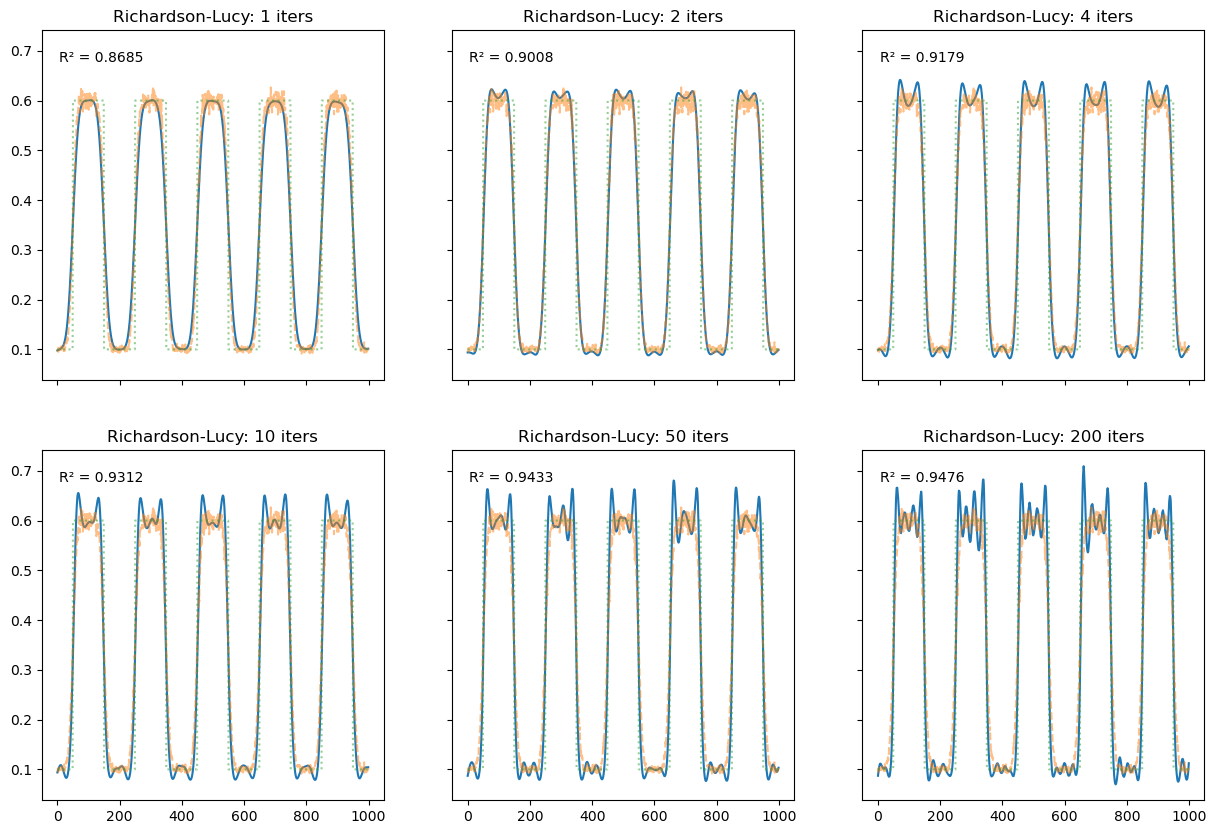

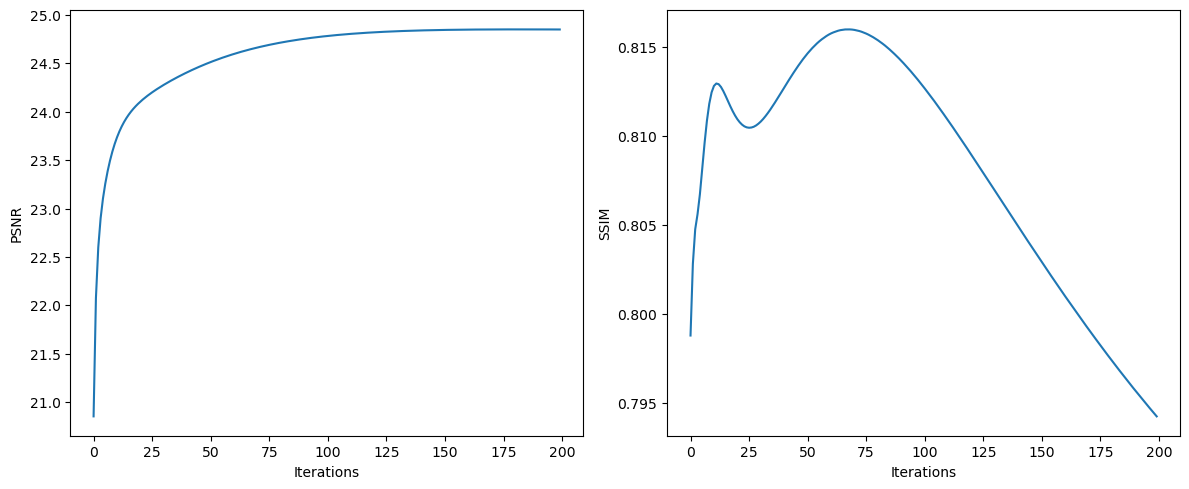

In [ ]:
plot_iterations_example(step_function, padding_mode='replicate', title = 'Replicate Padding', scale_factor = 5000, iters = [1,2,4,8,10,20,50,100,200], period = 2.0)

When the number of iterations are low the estimated signal is smooth and this doesn't reflect the shape of the true signal, especially around the vertical lines. As the number of iterations increases the shape of the estimated signal improves. The steepness of the lines from where the square wave changes value value increases. However as the number of iterations increases the noise from the estimated signal also increases. Often the signal will become noisy even when there is no noise in the measured signal.

It is clear from both the graph of $R^2$ score against iteration and the graph of MSE against iteration that the RLA is converging towards a solution. This solution doesn't appear to be the optimal solution since after 200 iterations the $R^2$ value hadn't yet hit $0.95$. Similarly the MSE seems to be converging to a value at about $0.003$.

(<Figure size 1200x500 with 2 Axes>,
 array([<Axes: xlabel='Iterations', ylabel='PSNR'>,
        <Axes: xlabel='Iterations', ylabel='SSIM'>], dtype=object))

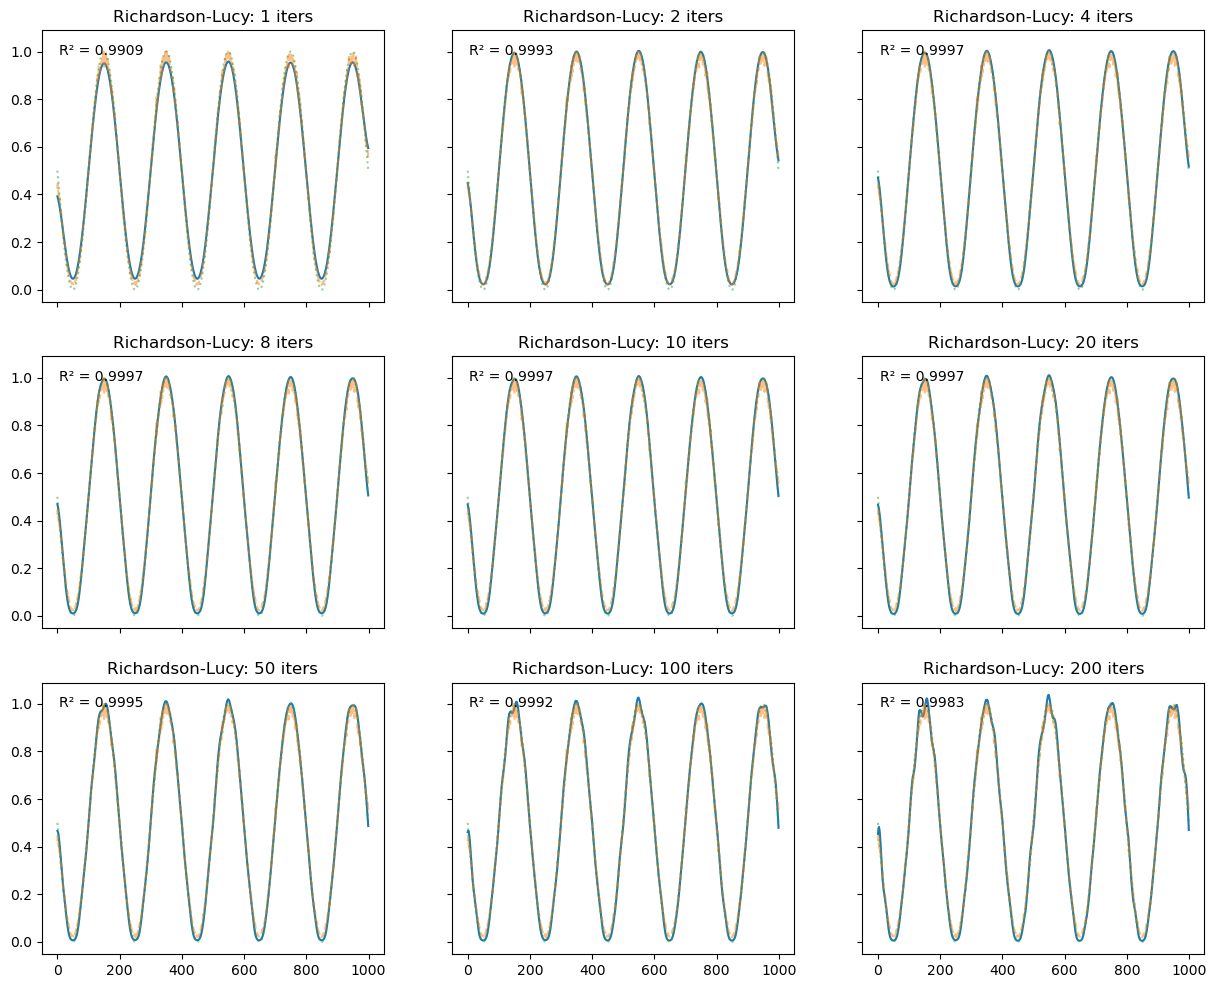

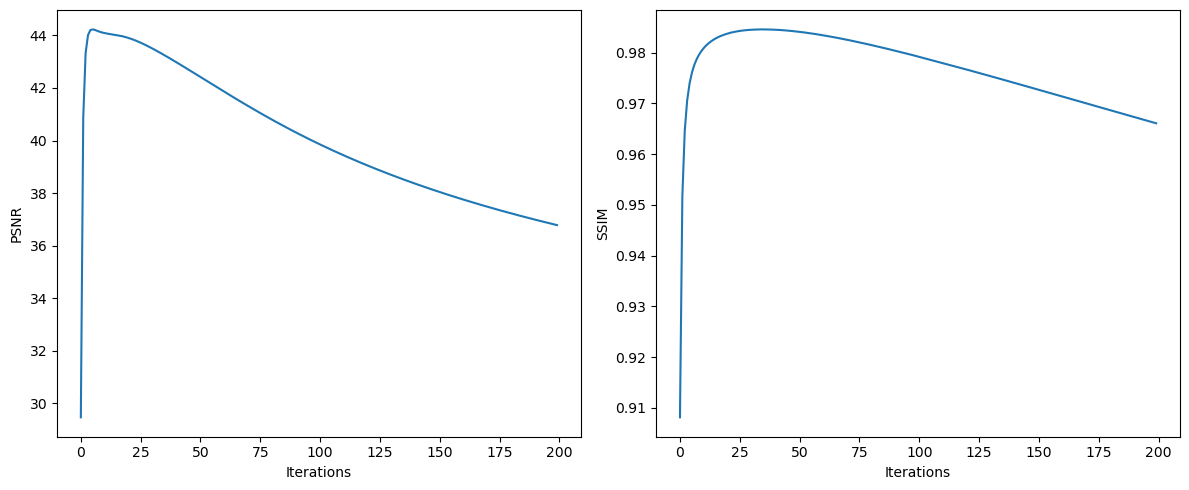

In [13]:
plot_iterations_example(sin_function, padding_mode='replicate', title = 'Replicate Padding', scale_factor = 5000, iters = [1,2,4,8,10,20,50,100,200])

In this example the convolution doesn't make so much difference to the true signal as its smoother. This means that there is less to be gained by carrying out more iterations of the RLA since the shape of the signal is already satisfactory. Carrying out more iterations just adds noise to the signal although this seems relativly insignificant as seen from the very large $R^2$ value of $0.998$.

Here the RLA initially gets very close to the true signal but then starts to diverge after 10 iterations. The reasons for this are unclear but may be to do with specific frequencies which the RLA is amplifying. By extending the graph it is clear that it doesn't seem to a solution after 1000 iterations, perhaps the rate of convergence is very slow.

(<Figure size 1200x500 with 2 Axes>,
 array([<Axes: xlabel='Iterations', ylabel='PSNR'>,
        <Axes: xlabel='Iterations', ylabel='SSIM'>], dtype=object))

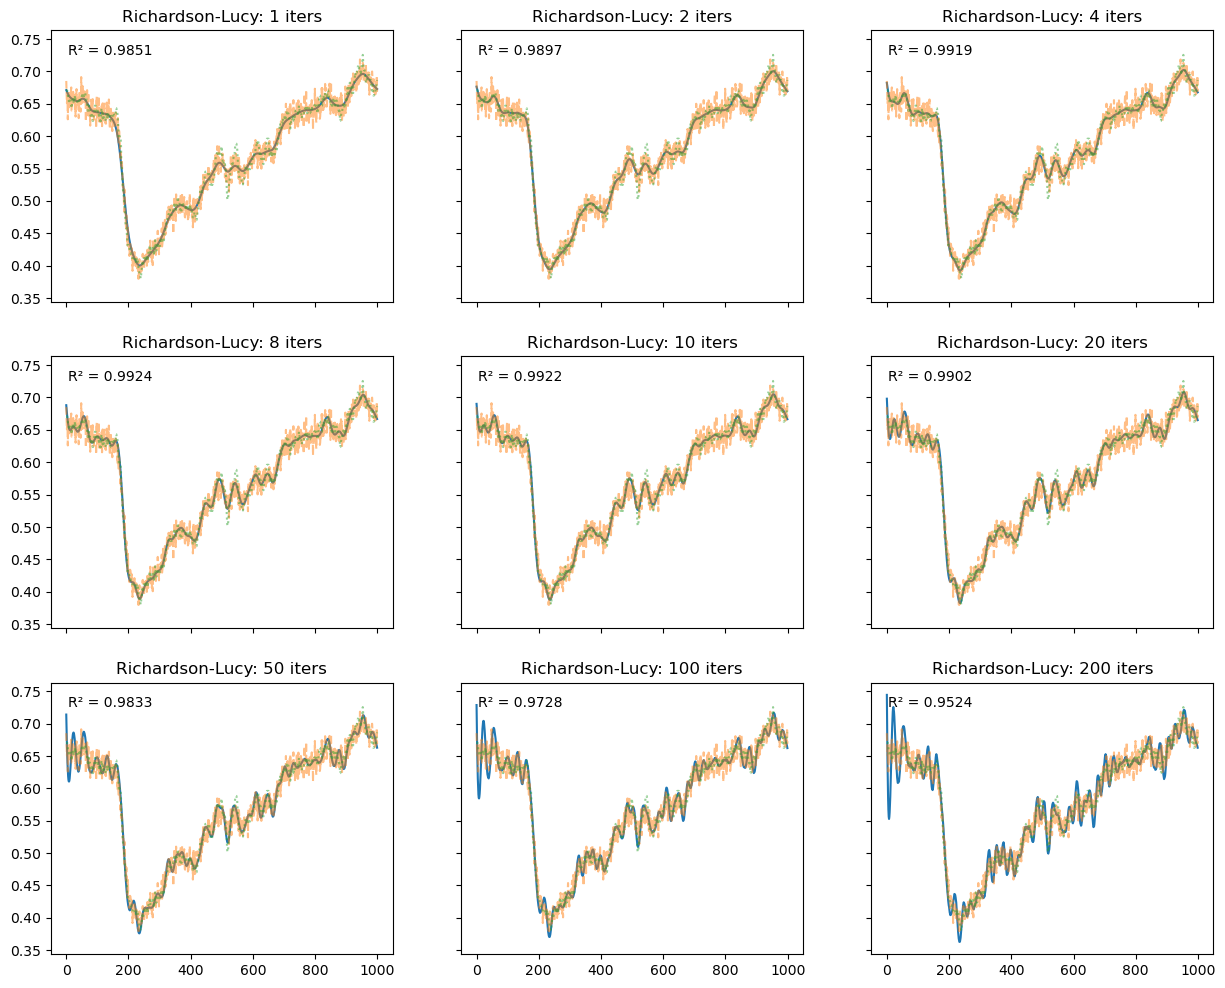

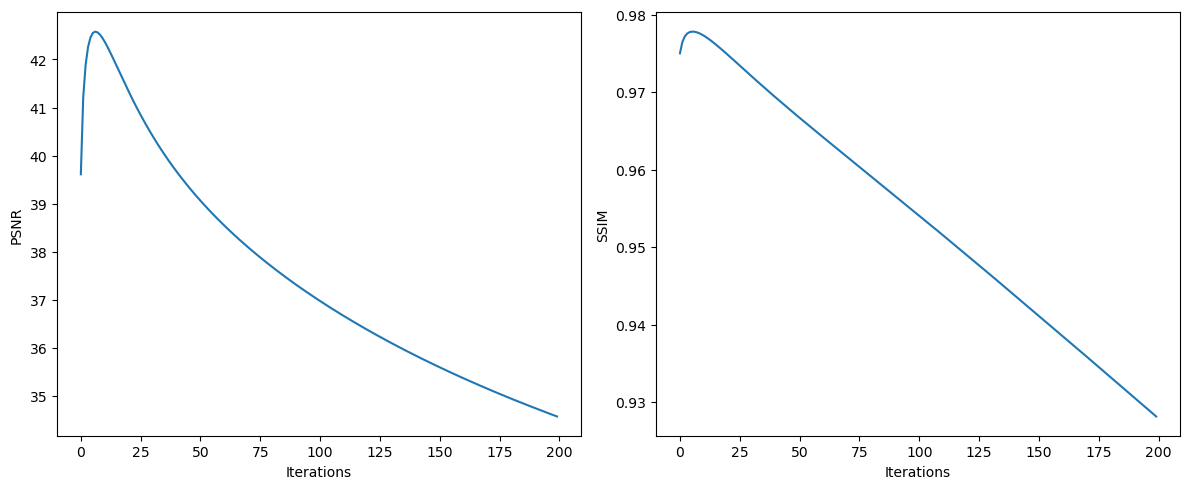

In [14]:
plot_iterations_example(pigeon_function, padding_mode='replicate', title = 'Replicate Padding', scale_factor = 5000, iters = [1,2,4,8,10,20,50,100,200])

After about 4 iterations the RLA has got as close as it gets to the true signal with a $R^2$ of about 0.993. After this the RLA diverges away from the true signal as the estimated signal becomes very noisy. The divergence in this case is much worse than in the previous example. This suggests that the number of iterations is an important variable to tune using machine learning.

## Conclusion
Padding is necessary to keep the signal size the same after convolution which is essential in the RLA. Replicate padding doesn't cause the images to darken over time and prevents artifacts being introduced into the solution due to boundary effects.

The number of iterations effects how close the estimated signal can get to the true signal. Selecting a number of iterations is a tradeoff between how well the shape of the estimated signal matches the true signal and how noisy the estimated signal is. The optimal number of iterations seems to be lower for real world signals perhaps due to the different frequency components of the signal.
